In [1]:
%autoreload 2

In [2]:
from collections import defaultdict, Counter
from itertools import combinations, chain
import json
from types import SimpleNamespace
import typing


import colorcet as cc
import krippendorff
from IPython.display import display, HTML, Markdown
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tabulate import tabulate


In [3]:
class ExtendedSimpleNamespace(SimpleNamespace):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __contains__(self, key):
        return hasattr(self, key)

    def __getitem__(self, key):
        return getattr(self, key)

    def get(self, key, default=None):
        return getattr(self, key, default)

    def keys(self):
        return [k for k in vars(self).keys() if not k.startswith("_")]
        

In [4]:
PREVIOUS_DATA_PATH = './human_evals_data/real-complete_only-main-pilot_01-27_data.json'
CURRENT_DATA_PATH = './human_evals_data/real-complete_only-main-pilot_01-27_data.json'

GAME_KEYS = [
    'id', 'real', 'matched', 
    'confident', 'fun_play', 'fun_watch', 
    'capability', 'goldilocks', 'creativity',
    'human-likeness', 'explain', 'overall'
]

RENAMED_GAME_KEYS = {
    'id': 'game_id',
    'human-likeness': 'human_likeness'
}

NUMBER_SCORE_ATTRIBUTES = [
    'confident', 'fun_play', 
    'fun_watch',  'capability', 
    'goldilocks', 'creativity',
    'human_likeness',
]

NUMBER_SCORE_AXIS_NAMES = {
    'confident': 'How confident are you that you understand the game?',
    'fun_play': 'How fun would it be to play the game yourself?',
    'fun_watch': 'How fun would it be to watch someone else play the game?',
    'capability': 'How helpful would it be for learning to interact',
    'goldilocks': 'Too easy, appropriately difficult, or too hard for you?',
    'creativity': 'How creatively designed is the game?',
    'human_likeness': 'How human-like do you think this game is?',
}


def load_data(data_path: str) -> typing.Tuple[typing.List[ExtendedSimpleNamespace], typing.List[ExtendedSimpleNamespace]]:
    with open(data_path, 'r') as f:
        raw_data = json.load(f, object_hook=lambda d: ExtendedSimpleNamespace(**d))

    prolific_participants_data = []
    non_prolific_participants_data = []

    for participant_data in raw_data:
        if participant_data.data.recruitment_service == 'prolific':
            prolific_participants_data.append(participant_data)
        else:
            non_prolific_participants_data.append(participant_data)

    return prolific_participants_data, non_prolific_participants_data


def real_matched_to_str(series: pd.Series) -> str:
    if series.real:
        return 'real'

    if series.matched:
        return 'matched'

    return 'unmatched'


def full_game_id_to_str(series: pd.Series) -> str:
    return f"{series.game_id}-{series.game_type}"


def loaded_data_to_df(loaded_data: typing.List[ExtendedSimpleNamespace]):
    rows = []

    for participant in loaded_data:
        participant_id = participant.id

        for game_result in participant.data.single_game_results:
            rows.append({
                'participant_id': participant_id,
                **{RENAMED_GAME_KEYS.get(key, key): game_result[key] for key in GAME_KEYS}
            })
    
    df = pd.DataFrame(rows)
    df = df.assign(game_type=pd.Categorical(df.apply(real_matched_to_str, axis=1), categories=['real', 'matched', 'unmatched'], ordered=True))
    df = df.assign(full_game_id=df.apply(full_game_id_to_str, axis=1))
    
    return df


def load_data_to_df(data_path: str, prolific_only: bool = True):
    prolific_participants_data, non_prolific_participants_data = load_data(data_path)
    if not prolific_only:
        prolific_participants_data.extend(non_prolific_participants_data)

    return prolific_participants_data, loaded_data_to_df(prolific_participants_data)


current_participants_raw_data, current_participants_df = load_data_to_df(CURRENT_DATA_PATH)
previous_participants_raw_data, previous_participants_df = load_data_to_df(PREVIOUS_DATA_PATH)
print(f'Loaded current participant data with shape {current_participants_df.shape} from {CURRENT_DATA_PATH}')
print(f'Loaded previous participant data with shape {previous_participants_df.shape} from {PREVIOUS_DATA_PATH}')

new_prolific_participant_ids = set(current_participants_df.participant_id) - set(previous_participants_df.participant_id)
print(f"{len(new_prolific_participant_ids)} new prolific participants:")
for participant_id in sorted(new_prolific_participant_ids):
    print(f"\t{participant_id}")

print(f'Dataframe shape: {current_participants_df.shape}')
current_participants_df.head()


Loaded current participant data with shape (639, 15) from ./human_evals_data/real-complete_only-main-pilot_01-27_data.json
Loaded previous participant data with shape (639, 15) from ./human_evals_data/real-complete_only-main-pilot_01-27_data.json
0 new prolific participants:
Dataframe shape: (639, 15)


,participant_id,game_id,real,matched,confident,fun_play,fun_watch,capability,goldilocks,creativity,human_likeness,explain,overall,game_type,full_game_id
0,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)",False,False,4,3,3,5,3,2,2,"The game is composed of two components. First,...",The instructions seem to be pretty straightfor...,unmatched,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)-unmatched"
1,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)",False,False,4,3,3,4,3,3,2,"First, you need to place the hexagon bin near ...",This games seems slightly more difficult that ...,unmatched,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)-unmatched"
2,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",True,True,4,2,2,5,4,3,2,"First, you need to put the bin next to the bed...",This game is more challenging than the prior t...,real,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)-real"
3,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",False,True,5,4,4,3,2,2,2,Place the bin next to the wall. Throw balls t...,This game has the simplest instructions. One c...,matched,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)-matched"
4,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)",False,False,1,1,1,1,5,1,3,Move chairs and then let them go so they end u...,I don't like this game. I don't really unders...,unmatched,"(1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)-unmatched"


In [5]:
[p.data.debrief_responses.comments for p in current_participants_raw_data]

['I wasn\'t sure how to answer the question regarding how "human-like" the game seems. The games were all virtual.',
 'This was very underpaid with all the writing and the number of games. ',
 'no',
 'no',
 'N/A',
 'No.',
 'You guys kinda catfished us, as far as the Writing Requirements for this assignment goes.',
 'No',
 'Thank you for the opportunity.',
 'Hello.',
 "I don't think I would actually want to play any of these games",
 '',
 'no',
 'none.',
 'No. Thank you!',
 '',
 'No',
 'I enjoyed the experiment. ',
 'no thank you for the opportunity',
 'Nothing that I can think of. Thank you and good luck on your project. ',
 'Thanks',
 'thank you',
 'No',
 'None',
 'This was pretty interesting! Thanks for the opportunity to contribute.',
 'no',
 'None.',
 "Nothing to add but it would be nice if there was a progress bar while we're evaluating these games as it nearly killed me trying to get through the last 2 evaluations with no end in sight.",
 '',
 'I used the text entry box to type o

In [6]:
def add_linebreaks(string: str, n_lines: int = 2, min_break_length: int = 36):
    if len(string) <= min_break_length:
        return string

    prev_break_index = 0
    line_parts = []

    for break_index in range(1, n_lines):
        break_index = string.find(' ', int(break_index * len(string) / n_lines))
        if break_index == -1:
            break

        line_parts.append(string[prev_break_index:break_index])
        prev_break_index = break_index + 1

    line_parts.append(string[prev_break_index:])
    return '\n'.join(line_parts)


## Per-participant spread on each question

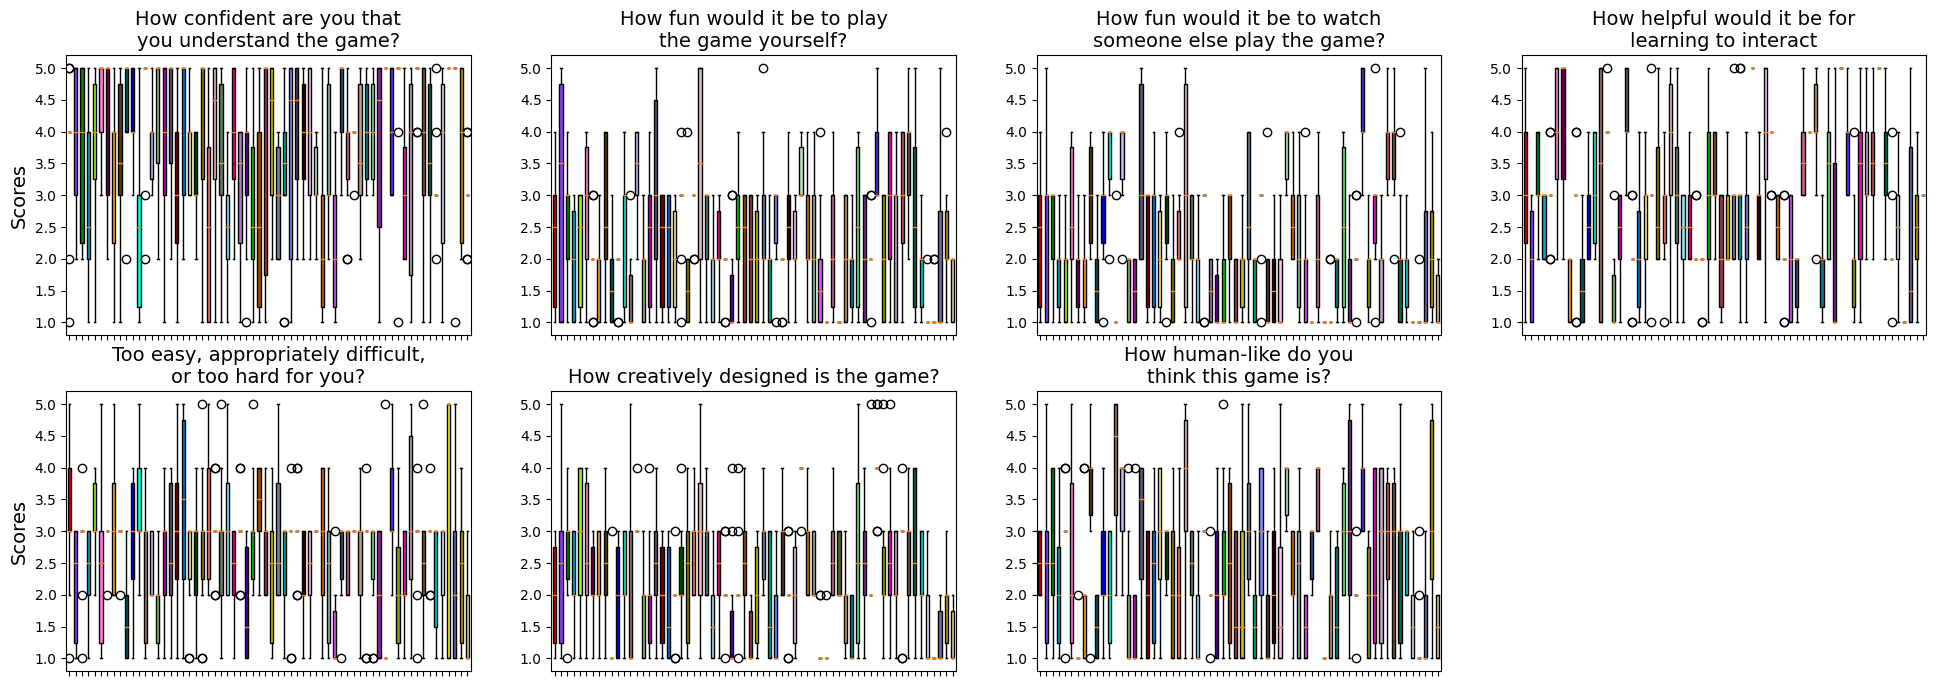

In [7]:
PANEL_HEIGHT = 4
PANEL_WIDTH = 6
NROWS = 2
NCOLS = 4
START_XLABELS_INDEX = 7
FONTDICT = dict(fontsize=14)

fig, axes = plt.subplots(NROWS, NCOLS, figsize=(PANEL_WIDTH * NCOLS, PANEL_HEIGHT * NROWS))
plt.subplots_adjust(hspace=0.2, wspace=0.2)
cmap = cc.cm.glasbey

grouped = current_participants_df.groupby('participant_id')
participant_ids = list(current_participants_df.participant_id.unique())
data_by_participant_id = {pid: {} for pid in participant_ids}

for i, (name, group) in enumerate(grouped):
    for attribute in NUMBER_SCORE_ATTRIBUTES:
        data_by_participant_id[name][attribute] = group[attribute].values


for i, (attribute, ax) in enumerate(zip(NUMBER_SCORE_ATTRIBUTES, chain.from_iterable(axes))):
    data = [data_by_participant_id[pid][attribute] for pid in participant_ids]
    positions = np.arange(len(data))
    bp = ax.boxplot(data, positions=positions, patch_artist=True)

    # Loop over each boxplot and set the color
    for b, box in enumerate(bp['boxes']):
        box.set_facecolor(cmap(b))

    ax.set_xticklabels([''] * len(participant_ids))
    if i % NCOLS == 0:
        ax.set_ylabel('Scores', fontdict=FONTDICT)

    ax.set_title(add_linebreaks(NUMBER_SCORE_AXIS_NAMES[attribute]), fontdict=FONTDICT)

    if i >= START_XLABELS_INDEX:
        ax.set_xticks(np.arange(len(participant_ids)))
        ax.set_xticklabels(participant_ids, rotation=90)
        ax.set_xlabel('Participant ID', fontdict=FONTDICT)

# clear the 8th axis
axes[-1][-1].axis('off')
plt.show()

## Per-game type bar plot on each questiion

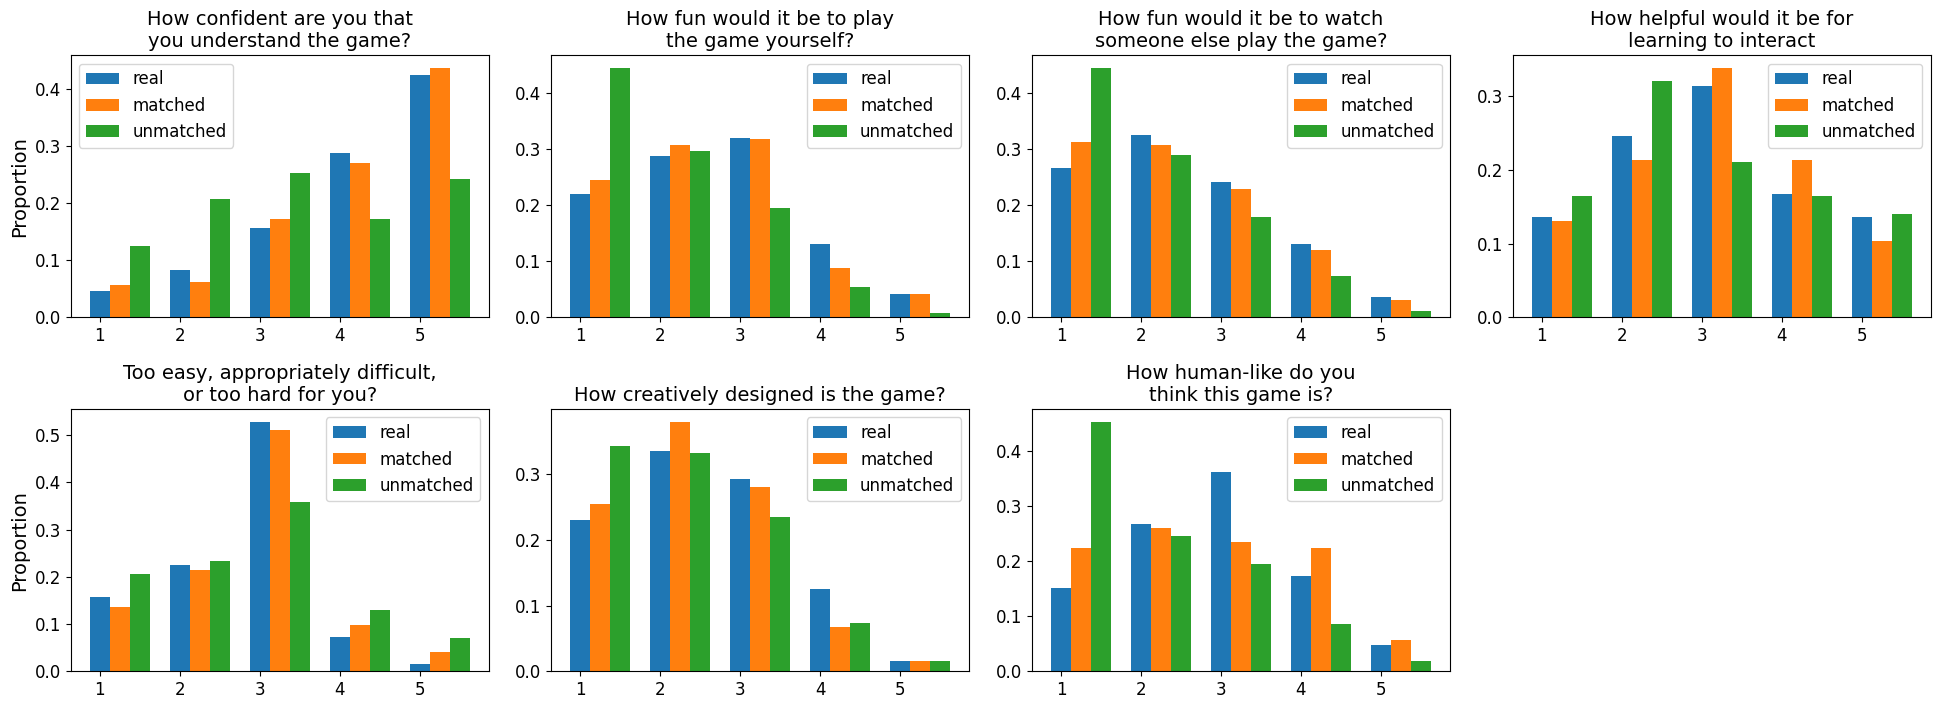

In [8]:
PANEL_HEIGHT = 4
PANEL_WIDTH = 6
NROWS = 2
NCOLS = 4
START_XLABELS_INDEX = 3
LEGEND_AX = 4
FONTDICT = dict(fontsize=14)
SEPARATE_PLOTS = False


if not SEPARATE_PLOTS:
    fig, axes = plt.subplots(NROWS, NCOLS, figsize=(PANEL_WIDTH * NCOLS, PANEL_HEIGHT * NROWS))
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    axes = list(chain.from_iterable(axes))

game_type_groupby = current_participants_df.groupby('game_type')
game_type_value_counts = current_participants_df.game_type.value_counts()

x = np.arange(5) + 1
width = 0.25
multiplier = 0

for i, attribute in enumerate(NUMBER_SCORE_ATTRIBUTES):
    if SEPARATE_PLOTS:
        fig, ax = plt.subplots(figsize=(PANEL_WIDTH, PANEL_HEIGHT))
    
    else:
        ax = axes[i]

    multiplier = 0
    for game_type in current_participants_df.game_type.cat.categories:
        offset = width * multiplier
        normalized_value_counts = game_type_groupby.get_group(game_type)[attribute].value_counts().sort_index() / game_type_value_counts[game_type]
        ax.bar(x + offset, normalized_value_counts, width=width, label=game_type)
        multiplier += 1

    ax.set_xlabel('')

    if i % NCOLS == 0:
        ax.set_ylabel('Proportion', fontdict=FONTDICT)

    # if i == LEGEND_AX:
    ax.legend(loc='best', fontsize=FONTDICT['fontsize'] - 2)

    ax.set_title(add_linebreaks(NUMBER_SCORE_AXIS_NAMES[attribute]), fontdict=FONTDICT)
    ax.tick_params(axis='both', which='major', labelsize=FONTDICT['fontsize'] - 2)

    if SEPARATE_PLOTS:
        plt.show()

if not SEPARATE_PLOTS:
    # clear the 8th axis
    axes[-1].axis('off')
    plt.show()


## Matched game difference comparison

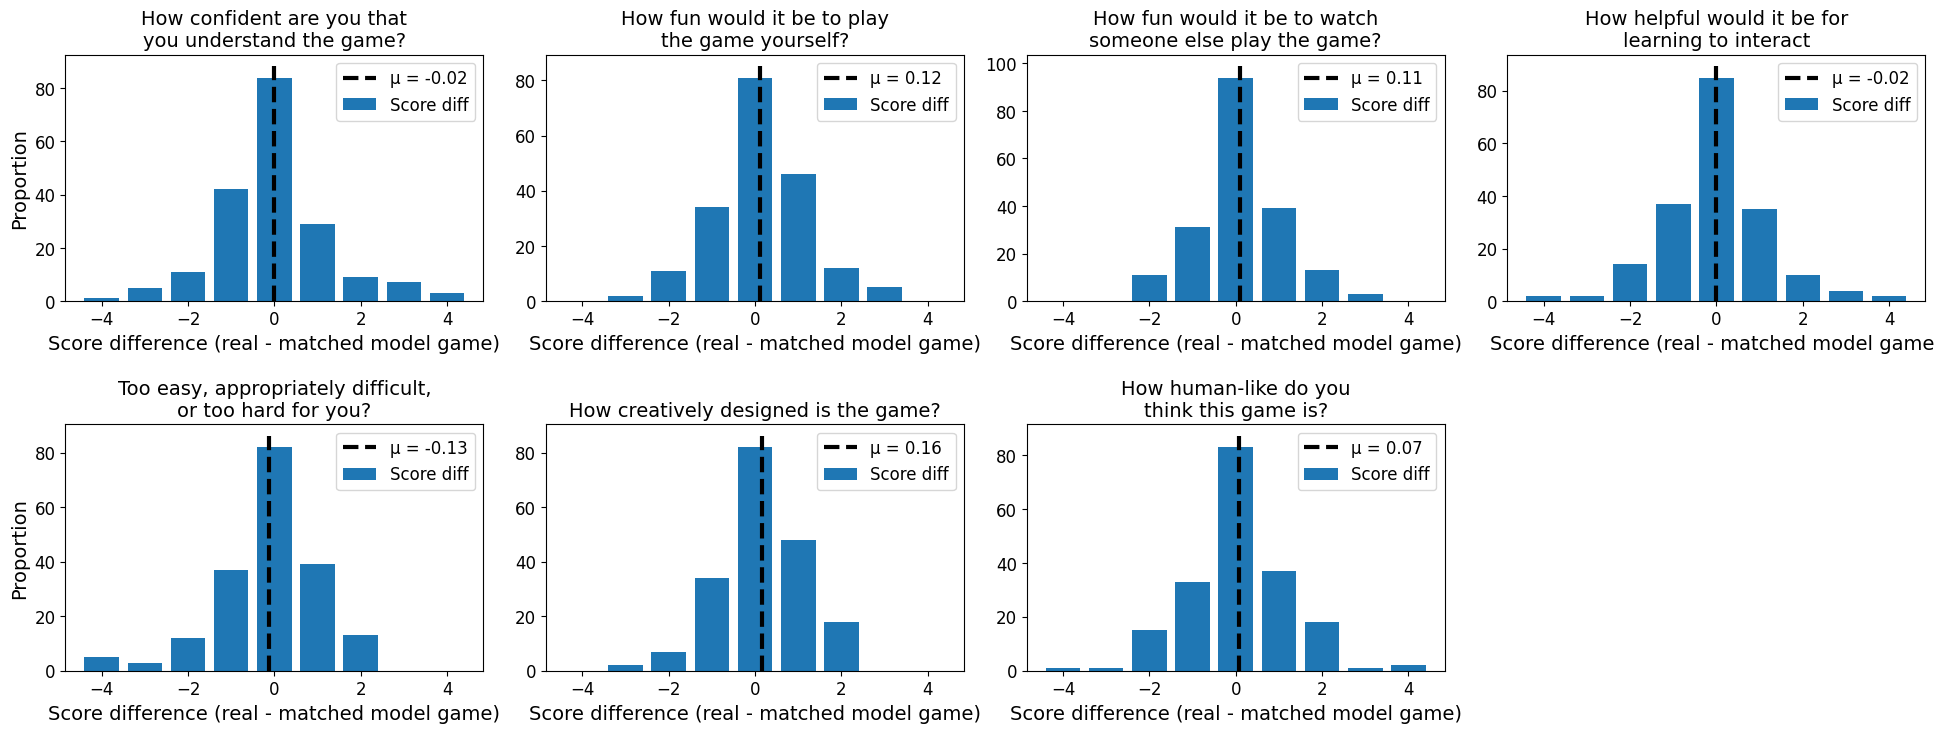

In [9]:
PANEL_HEIGHT = 4
PANEL_WIDTH = 6
NROWS = 2
NCOLS = 4
START_XLABELS_INDEX = 3
LEGEND_AX = 4
FONTDICT = dict(fontsize=14)

fig, axes = plt.subplots(NROWS, NCOLS, figsize=(PANEL_WIDTH * NCOLS, PANEL_HEIGHT * NROWS))
plt.subplots_adjust(hspace=0.5, wspace=0.15)

real_matched_df = current_participants_df[current_participants_df.game_type == 'real'].merge(
    current_participants_df[current_participants_df.game_type == 'matched'],
    on=['participant_id', 'game_id'],
    suffixes=('_real', '_matched')
)

x_values = np.arange(-4, 5)

for i, (attribute, ax) in enumerate(zip(NUMBER_SCORE_ATTRIBUTES, chain.from_iterable(axes))):
    attribute_diffs = real_matched_df[f'{attribute}_real'] - real_matched_df[f'{attribute}_matched']
    attribute_diff_counts = attribute_diffs.value_counts()
    ax.bar(x_values, [attribute_diff_counts.get(x, 0) for x in x_values], label='Score diff')
    ax.vlines(attribute_diffs.mean(), 0, ax.get_ylim()[1], color='black', label=f'\u03bc = {attribute_diffs.mean():.2f}', ls='--', lw=3)

    ax.set_xlabel('Score difference (real - matched model game)', fontdict=FONTDICT)

    if i % NCOLS == 0:
        ax.set_ylabel('Proportion', fontdict=FONTDICT)

    # if i == LEGEND_AX:
    ax.legend(loc='best', fontsize=FONTDICT['fontsize'] - 2)
    ax.set_title(add_linebreaks(NUMBER_SCORE_AXIS_NAMES[attribute]), fontdict=FONTDICT)
    ax.tick_params(axis='both', which='major', labelsize=FONTDICT['fontsize'] - 2)


# clear the 8th axis
axes[-1][-1].axis('off')
plt.show()



## Run some matched-pairs t-tests

In [10]:
real_matched_df = current_participants_df[current_participants_df.game_type == 'real'].merge(
    current_participants_df[current_participants_df.game_type == 'matched'],
    on=['participant_id', 'game_id'],
    suffixes=('_real', '_matched')
)


for attribute in NUMBER_SCORE_ATTRIBUTES:
    result = stats.ttest_rel(real_matched_df[f'{attribute}_real'], real_matched_df[f'{attribute}_matched'])
    stars = '*' * int(result.pvalue < 0.05) + '*' * int(result.pvalue < 0.01) + '*' * int(result.pvalue < 0.001)
    print(f'{attribute}:') 
    print(f'\tt-statistic = {result.statistic}')
    print(f'\tp-value = {result.pvalue} {stars}')
    print()
    

confident:
	t-statistic = -0.16649906191187544
	p-value = 0.8679412733630187 

fun_play:
	t-statistic = 1.5053186734955692
	p-value = 0.1339027709513395 

fun_watch:
	t-statistic = 1.5167506865350704
	p-value = 0.13099165422303055 

capability:
	t-statistic = -0.2359395265150154
	p-value = 0.8137337325143774 

goldilocks:
	t-statistic = -1.4908445104021752
	p-value = 0.1376606279312012 

creativity:
	t-statistic = 2.141132971616843
	p-value = 0.033537386090477996 *

human_likeness:
	t-statistic = 0.8545821417293136
	p-value = 0.3938587621295947 



## And some unmatched t-tests between the unmatched games and other ones

In [11]:
tab = '    '

for attribute in NUMBER_SCORE_ATTRIBUTES:
    print(f'{attribute}:') 
    for first, second in combinations(current_participants_df.game_type.cat.categories, 2):
        first_data = current_participants_df[current_participants_df.game_type == first][attribute]
        second_data = current_participants_df[current_participants_df.game_type == second][attribute]
        result = stats.ttest_ind(first_data, second_data)
        stars = '*' * int(result.pvalue < 0.05) + '*' * int(result.pvalue < 0.01) + '*' * int(result.pvalue < 0.001)
        print(f'{tab}{first} (\u03bc = {first_data.mean():.2f}) vs {second} (\u03bc = {second_data.mean():.2f})')
        print(f'{tab}{tab}t-statistic = {result.statistic:.3f}')
        print(f'{tab}{tab}tp-value    = {result.pvalue:.3e} {stars}')

    print()

    

confident:
    real (μ = 3.96) vs matched (μ = 3.97)
        t-statistic = -0.089
        tp-value    = 9.290e-01 
    real (μ = 3.96) vs unmatched (μ = 3.20)
        t-statistic = 6.246
        tp-value    = 9.825e-10 ***
    matched (μ = 3.97) vs unmatched (μ = 3.20)
        t-statistic = 6.315
        tp-value    = 6.546e-10 ***

fun_play:
    real (μ = 2.49) vs matched (μ = 2.38)
        t-statistic = 1.007
        tp-value    = 3.147e-01 
    real (μ = 2.49) vs unmatched (μ = 1.88)
        t-statistic = 6.186
        tp-value    = 1.399e-09 ***
    matched (μ = 2.38) vs unmatched (μ = 1.88)
        t-statistic = 5.101
        tp-value    = 4.996e-07 ***

fun_watch:
    real (μ = 2.35) vs matched (μ = 2.25)
        t-statistic = 0.837
        tp-value    = 4.030e-01 
    real (μ = 2.35) vs unmatched (μ = 1.92)
        t-statistic = 4.225
        tp-value    = 2.896e-05 ***
    matched (μ = 2.25) vs unmatched (μ = 1.92)
        t-statistic = 3.287
        tp-value    = 1.092e-03 **


## Trying to compute some inter-annotator agreement data

In [12]:
tab = '    '

for attribute in NUMBER_SCORE_ATTRIBUTES:
    print(f'{attribute}:') 
    pivot_table = pd.pivot_table(current_participants_df, values=attribute, index='participant_id', columns='full_game_id')
    alpha = krippendorff.alpha(pivot_table.values, level_of_measurement='ordinal')
    print(f'{tab}\u03b1 = {alpha:.3f}')
    pivot_table_real_matched_only = pd.pivot_table(current_participants_df[current_participants_df.game_type != 'unmatched'], values=attribute, index='participant_id', columns='full_game_id')
    alpha = krippendorff.alpha(pivot_table_real_matched_only.values, level_of_measurement='ordinal')
    print(f'{tab}\u03b1 (real and matched only) = {alpha:.3f}')

    print()




confident:
    α = 0.277
    α (real and matched only) = 0.223

fun_play:
    α = 0.132
    α (real and matched only) = 0.059

fun_watch:
    α = 0.075
    α (real and matched only) = 0.012

capability:
    α = -0.003
    α (real and matched only) = -0.004

goldilocks:
    α = 0.202
    α (real and matched only) = 0.210

creativity:
    α = 0.137
    α (real and matched only) = 0.128

human_likeness:
    α = 0.160
    α (real and matched only) = 0.092



# Repeating some analyses with normalized scores
Normalizing within each (participant X question)

In [13]:
current_participants_normalized_df = current_participants_df.copy()

participant_ids = current_participants_df.participant_id.unique()

for participant_id in participant_ids:
    for attribute in NUMBER_SCORE_ATTRIBUTES:
        attribute_mean = current_participants_normalized_df[current_participants_normalized_df.participant_id == participant_id][attribute].mean()
        attribute_std = current_participants_normalized_df[current_participants_normalized_df.participant_id == participant_id][attribute].std()

        if attribute_std == 0:
            current_participants_normalized_df.loc[current_participants_normalized_df.participant_id == participant_id, attribute] = 0
        else:
            current_participants_normalized_df.loc[current_participants_normalized_df.participant_id == participant_id, attribute] = (current_participants_normalized_df.loc[current_participants_normalized_df.participant_id == participant_id, attribute] - attribute_mean) / attribute_std


current_participants_normalized_df.head()
    

,participant_id,game_id,real,matched,confident,fun_play,fun_watch,capability,goldilocks,creativity,human_likeness,explain,overall,game_type,full_game_id
0,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)",False,False,0.239681,0.511166,0.511166,1.367198,-0.176166,0.000000,-0.948683,"The game is composed of two components. First,...",The instructions seem to be pretty straightfor...,unmatched,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)-unmatched"
1,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)",False,False,0.239681,0.511166,0.511166,0.607644,-0.176166,1.224745,-0.948683,"First, you need to place the hexagon bin near ...",This games seems slightly more difficult that ...,unmatched,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)-unmatched"
2,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",True,True,0.239681,-0.340777,-0.340777,1.367198,0.704664,1.224745,-0.948683,"First, you need to put the bin next to the bed...",This game is more challenging than the prior t...,real,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)-real"
3,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",False,True,1.038616,1.363108,1.363108,-0.151911,-1.056996,0.000000,-0.948683,Place the bin next to the wall. Throw balls t...,This game has the simplest instructions. One c...,matched,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)-matched"
4,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)",False,False,-2.157126,-1.192720,-1.192720,-1.671020,1.585495,-1.224745,0.948683,Move chairs and then let them go so they end u...,I don't like this game. I don't really unders...,unmatched,"(1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)-unmatched"


## Histogram of the values per question

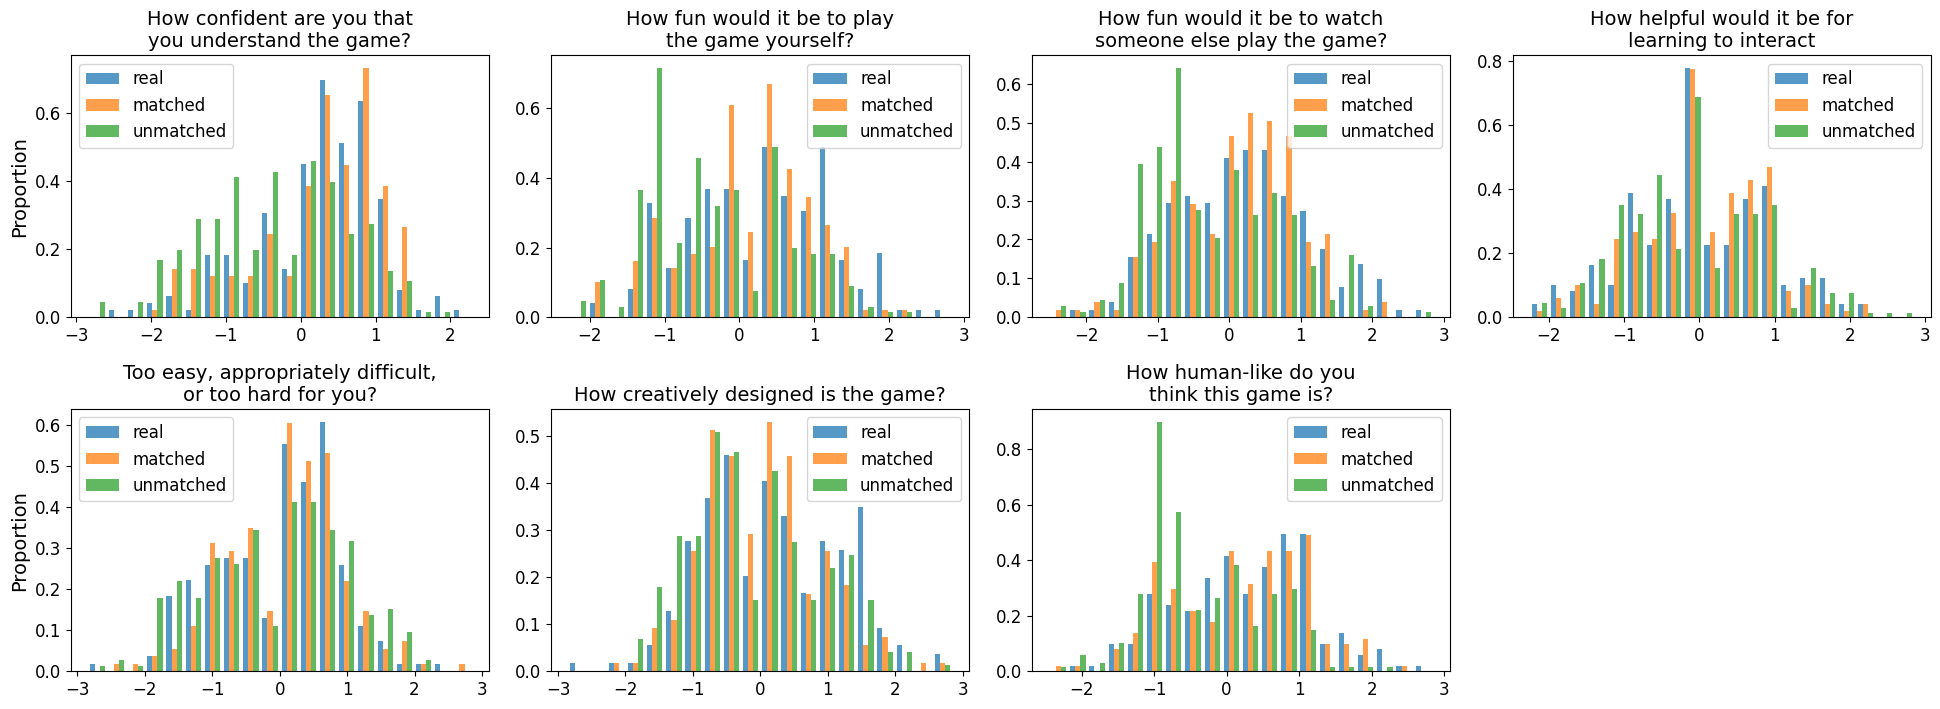

In [14]:
PANEL_HEIGHT = 4
PANEL_WIDTH = 6
NROWS = 2
NCOLS = 4
START_XLABELS_INDEX = 3
LEGEND_AX = 4
FONTDICT = dict(fontsize=14)
SEPARATE_PLOTS = False
N_BINS = 20

if not SEPARATE_PLOTS:
    fig, axes = plt.subplots(NROWS, NCOLS, figsize=(PANEL_WIDTH * NCOLS, PANEL_HEIGHT * NROWS))
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    axes = list(chain.from_iterable(axes))


x = np.arange(5) + 1
width = 0.25
multiplier = 0

for i, attribute in enumerate(NUMBER_SCORE_ATTRIBUTES):
    if SEPARATE_PLOTS:
        fig, ax = plt.subplots(figsize=(PANEL_WIDTH, PANEL_HEIGHT))
    
    else:
        ax = axes[i]

    histotgram_data = [current_participants_normalized_df[current_participants_normalized_df.game_type == game_type][attribute] for game_type in current_participants_df.game_type.cat.categories]
    ax.hist(histotgram_data, bins=N_BINS, label=current_participants_df.game_type.cat.categories, alpha=0.75, density=True)

    # for game_type in current_participants_df.game_type.cat.categories:
        # offset = width * multiplier
        # normalized_value_counts = game_type_groupby.get_group(game_type)[attribute].value_counts().sort_index() / game_type_value_counts[game_type]
        
        
        # ax.bar(x + offset, normalized_value_counts, width=width, label=game_type)
        # multiplier += 1

    ax.set_xlabel('')

    if i % NCOLS == 0:
        ax.set_ylabel('Proportion', fontdict=FONTDICT)

    # if i == LEGEND_AX:
    ax.legend(loc='best', fontsize=FONTDICT['fontsize'] - 2)

    ax.set_title(add_linebreaks(NUMBER_SCORE_AXIS_NAMES[attribute]), fontdict=FONTDICT)
    ax.tick_params(axis='both', which='major', labelsize=FONTDICT['fontsize'] - 2)

    if SEPARATE_PLOTS:
        plt.show()

if not SEPARATE_PLOTS:
    # clear the 8th axis
    axes[-1].axis('off')
    plt.show()


In [15]:
tab = '    '

for attribute in NUMBER_SCORE_ATTRIBUTES:
    print(f'{attribute}:') 
    for first, second in combinations(current_participants_normalized_df.game_type.cat.categories, 2):
        first_data = current_participants_normalized_df[current_participants_normalized_df.game_type == first][attribute]
        second_data = current_participants_normalized_df[current_participants_normalized_df.game_type == second][attribute]
        result = stats.ttest_ind(first_data, second_data)
        stars = '*' * int(result.pvalue < 0.05) + '*' * int(result.pvalue < 0.01) + '*' * int(result.pvalue < 0.001)
        print(f'{tab}{first} (\u03bc = {first_data.mean():.2f}) vs {second} (\u03bc = {second_data.mean():.2f})')
        print(f'{tab}{tab}t-statistic = {result.statistic:.3f}')
        print(f'{tab}{tab}tp-value    = {result.pvalue:.3e} {stars}')

    print()

    

confident:
    real (μ = 0.24) vs matched (μ = 0.26)
        t-statistic = -0.303
        tp-value    = 7.620e-01 
    real (μ = 0.24) vs unmatched (μ = -0.37)
        t-statistic = 6.986
        tp-value    = 1.040e-11 ***
    matched (μ = 0.26) vs unmatched (μ = -0.37)
        t-statistic = 7.283
        tp-value    = 1.490e-12 ***

fun_play:
    real (μ = 0.29) vs matched (μ = 0.14)
        t-statistic = 1.666
        tp-value    = 9.651e-02 
    real (μ = 0.29) vs unmatched (μ = -0.33)
        t-statistic = 7.094
        tp-value    = 5.169e-12 ***
    matched (μ = 0.14) vs unmatched (μ = -0.33)
        t-statistic = 5.605
        tp-value    = 3.653e-08 ***

fun_watch:
    real (μ = 0.23) vs matched (μ = 0.10)
        t-statistic = 1.431
        tp-value    = 1.532e-01 
    real (μ = 0.23) vs unmatched (μ = -0.25)
        t-statistic = 5.456
        tp-value    = 8.104e-08 ***
    matched (μ = 0.10) vs unmatched (μ = -0.25)
        t-statistic = 4.229
        tp-value    = 2.855e-

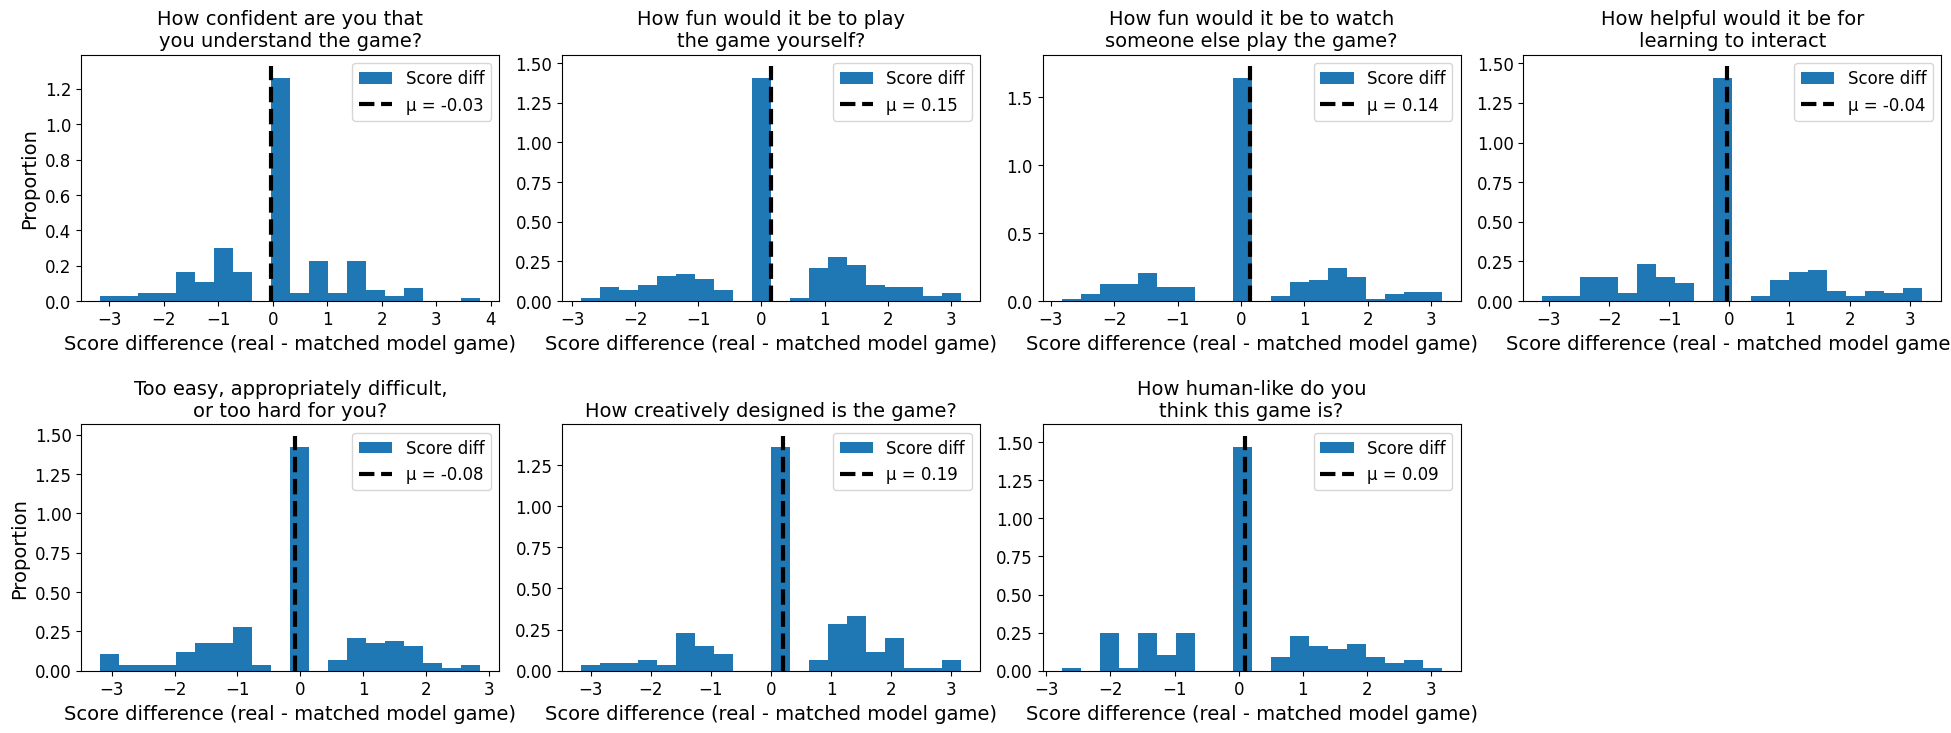

In [16]:
PANEL_HEIGHT = 4
PANEL_WIDTH = 6
NROWS = 2
NCOLS = 4
START_XLABELS_INDEX = 3
LEGEND_AX = 4
FONTDICT = dict(fontsize=14)
N_BINS = 20

fig, axes = plt.subplots(NROWS, NCOLS, figsize=(PANEL_WIDTH * NCOLS, PANEL_HEIGHT * NROWS))
plt.subplots_adjust(hspace=0.5, wspace=0.15)

real_matched_df = current_participants_normalized_df[current_participants_normalized_df.game_type == 'real'].merge(
    current_participants_normalized_df[current_participants_normalized_df.game_type == 'matched'],
    on=['participant_id', 'game_id'],
    suffixes=('_real', '_matched')
)

x_values = np.arange(-4, 5)

for i, (attribute, ax) in enumerate(zip(NUMBER_SCORE_ATTRIBUTES, chain.from_iterable(axes))):
    attribute_diffs = real_matched_df[f'{attribute}_real'] - real_matched_df[f'{attribute}_matched']
    # attribute_diff_counts = attribute_diffs.value_counts()
    ax.hist(attribute_diffs, bins=N_BINS, density=True, label='Score diff')
    ax.vlines(attribute_diffs.mean(), 0, ax.get_ylim()[1], color='black', label=f'\u03bc = {attribute_diffs.mean():.2f}', ls='--', lw=3)

    ax.set_xlabel('Score difference (real - matched model game)', fontdict=FONTDICT)

    if i % NCOLS == 0:
        ax.set_ylabel('Proportion', fontdict=FONTDICT)

    # if i == LEGEND_AX:
    ax.legend(loc='best', fontsize=FONTDICT['fontsize'] - 2)
    ax.set_title(add_linebreaks(NUMBER_SCORE_AXIS_NAMES[attribute]), fontdict=FONTDICT)
    ax.tick_params(axis='both', which='major', labelsize=FONTDICT['fontsize'] - 2)


# clear the 8th axis
axes[-1][-1].axis('off')
plt.show()



In [17]:
real_matched_df = current_participants_normalized_df[current_participants_normalized_df.game_type == 'real'].merge(
    current_participants_normalized_df[current_participants_normalized_df.game_type == 'matched'],
    on=['participant_id', 'game_id'],
    suffixes=('_real', '_matched')
)


for attribute in NUMBER_SCORE_ATTRIBUTES:
    result = stats.ttest_rel(real_matched_df[f'{attribute}_real'], real_matched_df[f'{attribute}_matched'])
    stars = '*' * int(result.pvalue < 0.05) + '*' * int(result.pvalue < 0.01) + '*' * int(result.pvalue < 0.001)
    print(f'{attribute}:') 
    print(f'\tt-statistic = {result.statistic}')
    print(f'\tp-value = {result.pvalue} {stars}')
    print()
    

confident:
	t-statistic = -0.3955487850736522
	p-value = 0.6928816931020645 

fun_play:
	t-statistic = 1.731643519818254
	p-value = 0.08496016194136352 

fun_watch:
	t-statistic = 1.5264304763989445
	p-value = 0.12856561588338533 

capability:
	t-statistic = -0.37928777736491215
	p-value = 0.7048977267906783 

goldilocks:
	t-statistic = -0.9569503070591158
	p-value = 0.33980837545450837 

creativity:
	t-statistic = 2.1223031036494047
	p-value = 0.03510758899634185 *

human_likeness:
	t-statistic = 1.0992014443924445
	p-value = 0.2730710603394282 



# Trying to run some mixed effects models

In [18]:
current_participants_normalized_df = current_participants_normalized_df.assign(
    game_type_real=pd.Series(current_participants_normalized_df.game_type == 'real', dtype=int),
    game_type_matched=pd.Series(current_participants_normalized_df.game_type == 'matched', dtype=int),
    game_type_unmatched=pd.Series(current_participants_normalized_df.game_type == 'unmatched', dtype=int),
    game_type=current_participants_normalized_df.game_type.cat.reorder_categories(['unmatched', 'matched', 'real']),
)

current_participants_normalized_df.head()

,participant_id,game_id,real,matched,confident,fun_play,fun_watch,capability,goldilocks,creativity,human_likeness,explain,overall,game_type,full_game_id,game_type_real,game_type_matched,game_type_unmatched
0,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)",False,False,0.239681,0.511166,0.511166,1.367198,-0.176166,0.000000,-0.948683,"The game is composed of two components. First,...",The instructions seem to be pretty straightfor...,unmatched,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)-unmatched",0,0,1
1,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)",False,False,0.239681,0.511166,0.511166,0.607644,-0.176166,1.224745,-0.948683,"First, you need to place the hexagon bin near ...",This games seems slightly more difficult that ...,unmatched,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)-unmatched",0,0,1
2,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",True,True,0.239681,-0.340777,-0.340777,1.367198,0.704664,1.224745,-0.948683,"First, you need to put the bin next to the bed...",This game is more challenging than the prior t...,real,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)-real",1,0,0
3,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",False,True,1.038616,1.363108,1.363108,-0.151911,-1.056996,0.000000,-0.948683,Place the bin next to the wall. Throw balls t...,This game has the simplest instructions. One c...,matched,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)-matched",0,1,0
4,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)",False,False,-2.157126,-1.192720,-1.192720,-1.671020,1.585495,-1.224745,0.948683,Move chairs and then let them go so they end u...,I don't like this game. I don't really unders...,unmatched,"(1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)-unmatched",0,0,1


In [19]:
# vc = {'participant_id': '0 + C(participant_id)'}
# md = smf.mixedlm('confident ~ game_type', current_participants_normalized_df, groups='game_type', vc_formula=vc)
# mdf = md.fit()

vc = {'full_game_id': '0 + C(full_game_id)'}
for attribute in NUMBER_SCORE_ATTRIBUTES:
    display(Markdown(f'### {attribute}:'))
    md = smf.mixedlm(f'{attribute} ~ game_type + 1', current_participants_normalized_df, groups='participant_id', vc_formula=vc)
    mdf = md.fit()
    display(mdf.summary())
    display(Markdown('-----------'))




### confident:

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:                MixedLM   Dependent Variable:   confident
No. Observations:     639       Method:               REML     
No. Groups:           64        Scale:                0.3916   
Min. group size:      9         Log-Likelihood:       -832.7544
Max. group size:      10        Converged:            Yes      
Mean group size:      10.0                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.371    0.055 -6.728 0.000 -0.479 -0.263
game_type[T.matched]  0.632    0.072  8.786 0.000  0.491  0.773
game_type[T.real]     0.606    0.071  8.508 0.000  0.467  0.746
full_game_id Var      0.392                                    
===============================================================

"""

-----------

### fun_play:

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:                MixedLM   Dependent Variable:   fun_play 
No. Observations:     639       Method:               REML     
No. Groups:           64        Scale:                0.4003   
Min. group size:      9         Log-Likelihood:       -839.7639
Max. group size:      10        Converged:            Yes      
Mean group size:      10.0                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.327    0.036 -8.975 0.000 -0.398 -0.255
game_type[T.matched]  0.470    0.041 11.320 0.000  0.388  0.551
game_type[T.real]     0.621    0.050 12.455 0.000  0.523  0.719
full_game_id Var      0.400                                    
===============================================================

"""

-----------

### fun_watch:

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:                MixedLM   Dependent Variable:   fun_watch
No. Observations:     639       Method:               REML     
No. Groups:           64        Scale:                0.4081   
Min. group size:      9         Log-Likelihood:       -845.9247
Max. group size:      10        Converged:            Yes      
Mean group size:      10.0                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.252    0.056 -4.484 0.000 -0.363 -0.142
game_type[T.matched]  0.356    0.081  4.414 0.000  0.198  0.514
game_type[T.real]     0.487    0.058  8.419 0.000  0.373  0.600
full_game_id Var      0.408                                    
===============================================================

"""

-----------

### capability:

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM   Dependent Variable:   capability
No. Observations:    639       Method:               REML      
No. Groups:          64        Scale:                0.4082    
Min. group size:     9         Log-Likelihood:       -845.9927 
Max. group size:     10        Converged:            Yes       
Mean group size:     10.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.061    0.056 -1.085 0.278 -0.171  0.049
game_type[T.matched]  0.121    0.085  1.414 0.157 -0.047  0.288
game_type[T.real]     0.082    0.053  1.555 0.120 -0.021  0.186
full_game_id Var      0.408                                    
===============================================================

"""

-----------

### goldilocks:

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM   Dependent Variable:   goldilocks
No. Observations:    639       Method:               REML      
No. Groups:          64        Scale:                0.4360    
Min. group size:     9         Log-Likelihood:       -866.9443 
Max. group size:     10        Converged:            Yes       
Mean group size:     10.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.064    0.052 -1.234 0.217 -0.165  0.037
game_type[T.matched]  0.147    0.086  1.701 0.089 -0.022  0.316
game_type[T.real]     0.065    0.089  0.732 0.464 -0.110  0.240
full_game_id Var      0.436                                    
===============================================================

"""

-----------

### creativity:

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM   Dependent Variable:   creativity
No. Observations:    639       Method:               REML      
No. Groups:          64        Scale:                0.4368    
Min. group size:     9         Log-Likelihood:       -867.4791 
Max. group size:     10        Converged:            Yes       
Mean group size:     10.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.124    0.058 -2.135 0.033 -0.238 -0.010
game_type[T.matched]  0.107    0.068  1.585 0.113 -0.025  0.240
game_type[T.real]     0.308    0.085  3.608 0.000  0.140  0.475
full_game_id Var      0.437                                    
===============================================================

"""

-----------

### human_likeness:

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:             MixedLM  Dependent Variable:  human_likeness
No. Observations:  639      Method:              REML          
No. Groups:        64       Scale:               0.3907        
Min. group size:   9        Log-Likelihood:      -832.0305     
Max. group size:   10       Converged:           Yes           
Mean group size:   10.0                                        
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.372    0.053 -7.051 0.000 -0.476 -0.269
game_type[T.matched]  0.574    0.043 13.486 0.000  0.491  0.658
game_type[T.real]     0.668    0.084  7.927 0.000  0.503  0.833
full_game_id Var      0.391                                    
===============================================================

"""

-----------